# Hello PyTorch Convolutional Neural Network CNN classifier for CIFAR-10 Image Dataset

In [1]:
# Prerequisites
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Python Version: ", sys.version)

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from tqdm import tqdm

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


Check for Cuda availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


### Data Preparation

In [3]:
# Normalize and transform the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset, download if not present
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# define the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


### Define the Convolutional Neural Network (CNN)

In [4]:
class CNN(nn.Module):
    def __init__(self, nr_classes):
        super(CNN, self).__init__()
        # Define 3 Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, nr_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [7]:
# Check CNN structure
print(CNN(10))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


### Instantiate the CNN

In [8]:
# Instantiate the model
model = CNN(nr_classes=10).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)


### Train the CNN 

In [9]:
nr_epochs = 50

prog_bar = tqdm(range(nr_epochs), desc="Training Progress", unit="epoch")

# Training loop
for epoch in range(nr_epochs):
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        log_probs = model(images)
        loss = criterion(log_probs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update progress bar
    prog_bar.set_postfix(loss=running_loss)
    prog_bar.update(1)

# Close the progress bar
prog_bar.close()    

Training Progress: 100%|██████████| 50/50 [06:39<00:00,  7.98s/epoch, loss=148]   


### Save and Load the model

In [10]:
# Save the model
torch.save(model.state_dict(), "./saved_models/cnn_cifar10.pth")

In [11]:
# Load the model for inference
model.load_state_dict(torch.load("./saved_models/cnn_cifar10.pth"))

<All keys matched successfully>

In [12]:
model = model.to(device)

### Run Inference and Evaluate Model

In [13]:
nr_correct = 0
nr_total = 0

with torch.no_grad():   # Do not calculate gradients
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        # Inference
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        nr_total += labels.size(0)
        nr_correct += (predicted == labels).sum().item()

    print("Accuracy of 10000 test images: ", 100 * nr_correct / nr_total, "%")


Accuracy of 10000 test images:  64.53 %


### Analyze Results

In [14]:
# Helper function to display image
def disp_img(img):
    img = img*0.5 + 0.5    # unnormalize
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))   # Transpose the image to (H, W, C)
    plt.xticks([])
    plt.yticks([])


# Helper function to display image and predictions 
def disp_img_pred(imgages, labels, predicted, classes, nr_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(nr_images):
        ax = plt.subplot(2, 5, i+1)
        disp_img(imgages[i])
        ax.set_title(f"Actual: {classes[labels[i]]}, Pred: {classes[predicted[i]]}")
        plt.tight_layout()

    plt.show()
    

Display 10 images

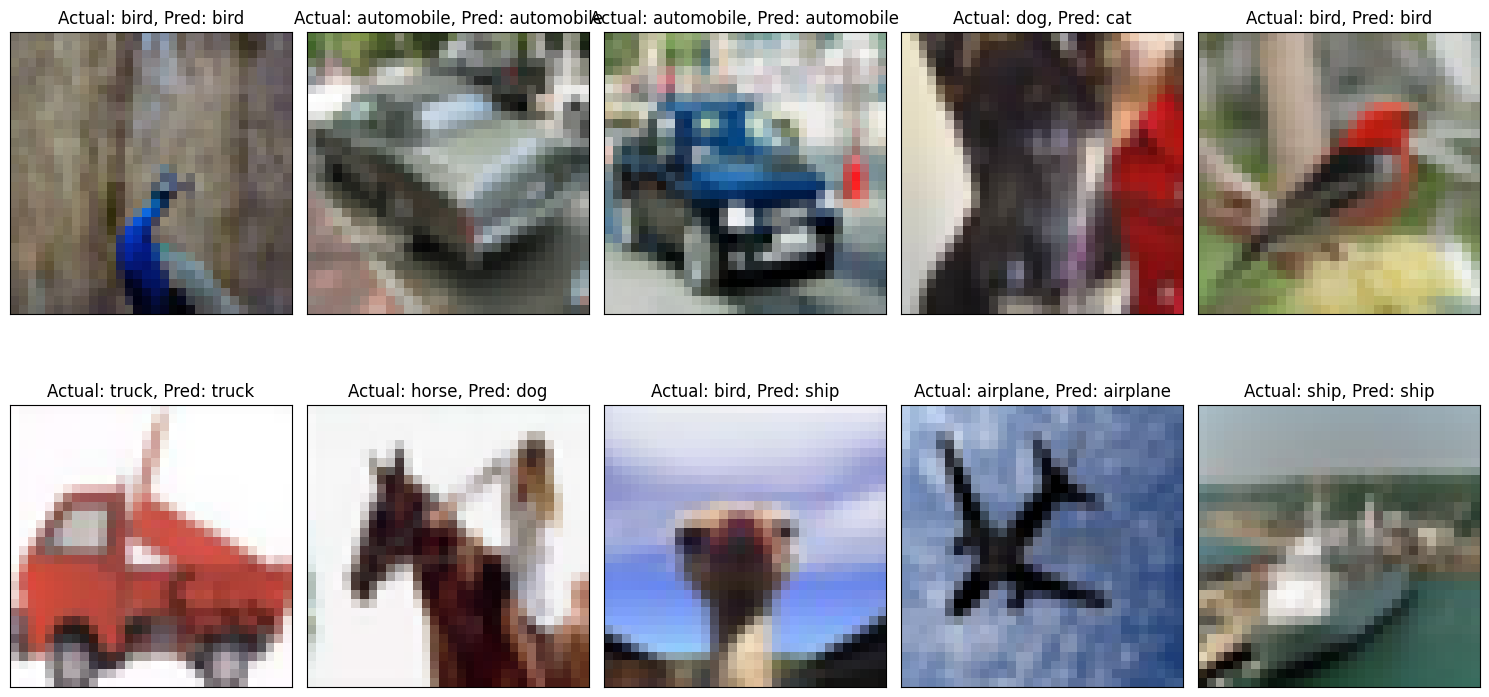

In [15]:
images = images.to("cpu")
labels = labels.to("cpu")

classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]

disp_img_pred(images, labels, predicted, classes, nr_images=10)


Analyze performance per class

In [16]:
nr_classes = 10
correct_per_class = [0] * nr_classes
total_per_class = [0] * nr_classes
true_positive = [0] * nr_classes
false_positive = [0] * nr_classes
false_negative = [0] * nr_classes

# Run Evaluation Loop   
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    for label, prediction in zip(labels, predicted):
        if label == prediction:
            correct_per_class[label] += 1
            true_positive[label] += 1
        else:
            false_positive[prediction] += 1
            false_negative[label] += 1

        total_per_class[label] += 1


accuracy_per_class = [100*tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(true_positive, false_positive)]
recall_per_class = [100*tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(true_positive, false_negative)]
overall_accuracy = 100 * sum(correct_per_class) / sum(total_per_class)

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print("Accuracy per Class:")
for i in range(nr_classes):
    print(f"Class {classes[i]}: Accuracy: {accuracy_per_class[i]:.2f}%,"
          f" Recall: {recall_per_class[i]:.2f}%")
    

Overall Accuracy: 62.50%
Accuracy per Class:
Class airplane: Accuracy: 66.67%, Recall: 100.00%
Class automobile: Accuracy: 100.00%, Recall: 50.00%
Class bird: Accuracy: 50.00%, Recall: 100.00%
Class cat: Accuracy: 50.00%, Recall: 50.00%
Class deer: Accuracy: 50.00%, Recall: 33.33%
Class dog: Accuracy: 0.00%, Recall: 0.00%
Class frog: Accuracy: 50.00%, Recall: 50.00%
Class horse: Accuracy: 100.00%, Recall: 50.00%
Class ship: Accuracy: 100.00%, Recall: 100.00%
Class truck: Accuracy: 0.00%, Recall: 0.00%
